In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [59]:
from tg_math_lib.geometry import line_line_shortest_dist_bounded

In [25]:
def closest_dist_cvxpy(r1, v1, r2, v2):
    t1 = cp.Variable()
    t2 = cp.Variable()
    obj = cp.Minimize(cp.norm2((r1 + v1 * t1) - (r2 + v2 * t2)))
    constraints = [
        t1 >= 0,
        t1 <= 1,
        t2 >= 0,
        t2 <= 1,
    ]
    prob = cp.Problem(obj, constraints)
    soln = prob.solve()
    return soln, (t1.value, t2.value)

In [167]:
def two_lines_closest_dist_unbounded(r1, v1, r2, v2):
    R = r2 - r1
    A = np.array([[np.dot(v1, v1), -np.dot(v1, v2)],
                  [np.dot(v2, v1), -np.dot(v2, v2)]])
    b = np.array([np.dot(R, v1), np.dot(R, v2)])
    t1, t2 = np.matmul(np.linalg.inv(A), b)
    return t1, t2

In [255]:
# def line_and_point_closest_dist(r1, v1, pt):
#     return np.dot(v1, r1 - pt) / np.dot(v1, v1)

In [360]:
def closest_dist(r1, v1, r2, v2, eps=1e-6):

    dist = lambda t1, t2: np.linalg.norm((r1 + v1 * t1) - (r2 + v2 * t2))
    
    # check against unbounded version first if not parallel
    if np.dot(v1, v2) < np.linalg.norm(v1) * np.linalg.norm(v2) - eps:
        t1, t2 = two_lines_closest_dist_unbounded(r1, v1, r2, v2)
        if 0 <= t1 <= 1 and 0 <= t2 <= 1:
            # already found optimum, can exit
            return dist(t1, t2)
    
    # enters here if unbounded optimal not in feasible region
    # solution therefore must be on the boundary
    # so check all edges and corners
    best_dist = np.inf
    best_t1, best_t2 = None, None
    
    for t1_fixed in [0, 1, None]:
        
        for t2_fixed in [0, 1, None]:
            
            if t1_fixed is None and t2_fixed is None:
                # this case not on edge, skipped
                continue
            elif t1_fixed is None:
                # case when t2_guess fixed
                t1_guess = (np.dot(v1, v2) * t2_fixed - np.dot(r1 - r2, v1)) / np.dot(v1, v1)
                t2_guess = t2_fixed
            elif t2_fixed is None:
                # case when t1_guess fixed
                t1_guess = t1_fixed
                t2_guess = (np.dot(v1, v2) * t1_fixed + np.dot(r1 - r2, v2)) / np.dot(v2, v2)
            else:
                t1_guess = t1_fixed
                t2_guess = t2_fixed
                        
            if 0 <= t1_guess <= 1 and 0 <= t2_guess <= 1:
                # only consider if the terms are in the bounds
                d = dist(t1_guess, t2_guess)
                if d < best_dist:
                    best_dist = d
                    best_t1 = t1_guess
                    best_t2 = t2_guess
    
    return best_dist

In [78]:
r1 = np.array([1, 0, 0])
r2 = np.array([0, 1, 0])
v1 = np.array([1, 2, 0])
v2 = np.array([-0.2, -0.4, 0])

In [79]:
%time _, (t1_cvxpy, t2_cvxpy) = closest_dist_cvxpy(r1, v1, r2, v2)

CPU times: user 13.3 ms, sys: 552 µs, total: 13.9 ms
Wall time: 13.6 ms


In [80]:
%time _, (t1, t2) = line_line_shortest_dist_bounded(r1, v1, r2, v2, return_t=True)

CPU times: user 215 µs, sys: 66 µs, total: 281 µs
Wall time: 227 µs


<a list of 7 text.Text objects>

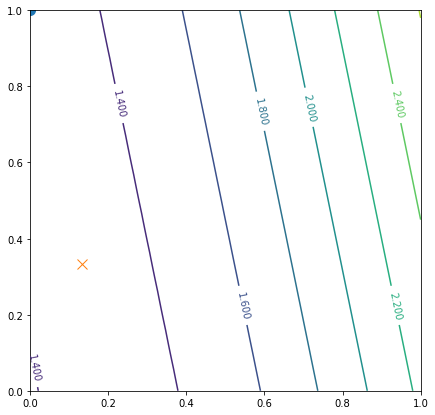

In [81]:
t1s = np.linspace(0, 1)
t2s = np.linspace(0, 1)
plt.figure(figsize=(7, 7))
CS = plt.contour(t1s, t2s, [[np.linalg.norm((r1 + v1 * t1) - (r2 + v2 * t2)) for t1 in t1s] for t2 in t2s])
plt.plot([t1], [t2], 'o', markersize=10)
plt.plot([t1_cvxpy], [t2_cvxpy], 'x', markersize=10)
plt.clabel(CS, CS.levels, inline=True)

In [90]:
for _ in range(100):
    r1 = np.random.rand(3)
    r2 = np.random.rand(3)
    v1 = np.random.rand(3)
    v2 = np.random.rand(3)
    _, ans1 = line_line_shortest_dist_bounded(r1, v1, r2, v2, return_t=True)
    _, ans2 = closest_dist_cvxpy(r1, v1, r2, v2)
    np.testing.assert_array_almost_equal(ans1, ans2, decimal=4)

In [91]:
print(r1, r2, v1, v2)

[0.02220415 0.51176983 0.09934784] [0.59239106 0.52543449 0.84187871] [0.15278532 0.52724277 0.54122267] [0.49407423 0.1957999  0.94259345]


In [92]:
print("no cvx   ", np.linalg.norm((r1 + v1 * ans1[0]) - (r2 + v2 * ans1[1]))) 
print("with cvx ", np.linalg.norm((r1 + v1 * ans2[0]) - (r2 + v2 * ans2[1])))

no cvx    0.6799499074570258
with cvx  0.6799499075966775


<a list of 6 text.Text objects>

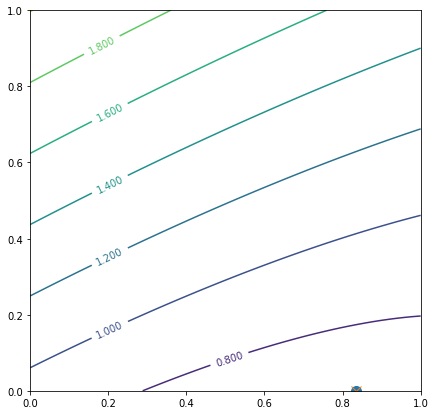

In [93]:
t1s = np.linspace(0, 1)
t2s = np.linspace(0, 1)
plt.figure(figsize=(7, 7))
CS = plt.contour(t1s, t2s, [[np.linalg.norm((r1 + v1 * t1) - (r2 + v2 * t2)) for t1 in t1s] for t2 in t2s])
plt.plot([ans1[0]], [ans1[1]], 'o', markersize=10)
plt.plot([ans2[0]], [ans2[1]], 'x', markersize=10)
plt.clabel(CS, CS.levels, inline=True)

In [56]:
rand_vects = [[np.random.rand(3) for _ in range(4)] for _ in range(1000)]

In [62]:
%time all_ans = [line_line_shortest_dist_bounded(r1, v1, r2, v2) for r1, v1, r2, v2 in rand_vects]

CPU times: user 247 ms, sys: 24.2 ms, total: 271 ms
Wall time: 142 ms


In [63]:
%time all_ans_cvxpy = [closest_dist_cvxpy(r1, v1, r2, v2)[0] for r1, v1, r2, v2 in rand_vects]

CPU times: user 12.8 s, sys: 134 ms, total: 13 s
Wall time: 13.8 s


In [64]:
np.testing.assert_array_almost_equal(all_ans, all_ans_cvxpy)

In [65]:
#check parallel cases
rand_vects = [[np.random.rand(3) for _ in range(4)] for _ in range(1000)]
for i in range(len(rand_vects)):
    rand_vects[i][3] = rand_vects[i][1] * 2 * (np.random.rand() - 0.5)

In [67]:
%time all_ans = [line_line_shortest_dist_bounded(r1, v1, r2, v2) for r1, v1, r2, v2 in rand_vects]

CPU times: user 82 ms, sys: 1.91 ms, total: 83.9 ms
Wall time: 84 ms


In [68]:
%time all_ans_cvxpy = [closest_dist_cvxpy(r1, v1, r2, v2)[0] for r1, v1, r2, v2 in rand_vects]

CPU times: user 11.2 s, sys: 52.8 ms, total: 11.2 s
Wall time: 11.3 s


In [69]:
np.testing.assert_array_almost_equal(all_ans, all_ans_cvxpy)